<a href="https://colab.research.google.com/github/gkianfar/TIHM-Dataset-Visualization/blob/main/tihm_featureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [261]:
!pip install lime

**Clone Github repo and set working directory path**

In [117]:
!git clone https://github.com/gkianfar/TIHM-Dataset-Visualization

fatal: destination path 'TIHM-Dataset-Visualization' already exists and is not an empty directory.


**Load packages**

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.patches as mpatches
from collections.abc import Iterable
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from matplotlib import cm
#from utils import *

%matplotlib inline
## Set colour palette
ibm_colorblind = ['#648FFF', '#FE6100', '#DC267F', '#785EF0', '#FFB000','#48A9A6']
sns.set_palette(ibm_colorblind)

**Functions**

In [119]:
def correct_col_type(df,col):
    raw_type = str(type(df[col].dtype)).split('.')[-1].split('\'')[0].lower()
    #print(col,raw_type)
    if 'object' in raw_type:
        if 'date' in col or 'timestamp' in col or 'datetime' in col:
            return pd.to_datetime(df[col])
        else:
            return df[col].astype('category')
    else:
        return df[col]


def gen_date_col(df, tcol):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df[tcol].dt.date
    return df





**Set Data and Fig folders paths**

In [120]:
## Please change the path with the path of your dataset
%cd /content/TIHM-Dataset-Visualization
DPATH = './Data'
SAVE_PATH = './Figs/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)



/content/TIHM-Dataset-Visualization


**Import Files**

In [ ]:
### Labels
f = 'Labels.csv'
fpth = os.path.join(DPATH,f)
labels_df = pd.read_csv(fpth)
for col in labels_df.columns:
    labels_df[col] = correct_col_type(labels_df,col)
if 'date' in labels_df.columns:
    labels_df = labels_df.rename(columns={'date':'timestamp'})
    labels_df['timestamp'] = pd.to_datetime(labels_df['timestamp'])
    labels_df['date'] = labels_df['timestamp'].dt.date
if 'type' in labels_df.columns:
    labels_df = labels_df.rename(columns={'type':'label'})

In [ ]:
### Activity

f = 'Activity.csv'
fpth = os.path.join(DPATH,f)
df = pd.read_csv(fpth)
for col in df.columns:
    df[col] = correct_col_type(df,col)
if 'date' in df.columns:
    activity_df = df.rename(columns={'date':'timestamp'})
    activity_df['timestamp'] = pd.to_datetime(activity_df['timestamp'])
    activity_df['date'] = activity_df['timestamp'].dt.date
    activity_df['time'] = activity_df['timestamp'].dt.time


activity_patients = np.unique(activity_df['patient_id'])

In [ ]:
### Physiology
f = 'Physiology.csv'
fpth = os.path.join(DPATH,f)
df = pd.read_csv(fpth)
for col in df.columns:
    df[col] = correct_col_type(df,col)
if 'date' in df.columns:
    physiology_df = df.rename(columns={'date':'timestamp'})
    physiology_df['timestamp'] = pd.to_datetime(physiology_df['timestamp'])
    physiology_df['date'] = physiology_df['timestamp'].dt.date
#physiology_df = gen_date_col(df,tcol='timestamp')

physiology_patients = np.unique(physiology_df['patient_id'])
physiology_parameters = np.unique(df['device_type'])

In [ ]:
# Sleep
f = 'Sleep.csv'
fpth = os.path.join(DPATH,f)
df = pd.read_csv(fpth)
for col in df.columns:
    df[col] = correct_col_type(df,col)
if 'date' in df.columns:
    sleep_df = df.rename(columns={'date':'timestamp'})
    sleep_df['timestamp'] = pd.to_datetime(sleep_df['timestamp'])
    sleep_df['date'] = sleep_df['timestamp'].dt.date
#physiology_df = gen_date_col(df,tcol='timestamp')

sleep_patients = np.unique(sleep_df['patient_id'])

In [ ]:
f = 'Demographics.csv'
fpth = os.path.join(DPATH,f)
demographics_df = pd.read_csv(fpth)
for col in demographics_df.columns:
    demographics_df[col] = correct_col_type(demographics_df,col)
if 'date' in demographics_df.columns:
    demographics_df = demographics_df.rename(columns={'date':'timestamp'})
    demographics_df['timestamp'] = pd.to_datetime(demographics_df['timestamp'])
    demographics_df['date'] = demographics_df['timestamp'].dt.date

In [ ]:
seed = 2025  # Set your desired seed value

# Set seed for Python's random module
random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)

interval = 6 # backward Time Window
agitation_df = labels_df[labels_df['label']=='Agitation'].copy()


agitation_patientID = agitation_df['patient_id'].tolist()
agitation_endTime = agitation_df['timestamp'].tolist()

agitation_startTime = pd.to_datetime(agitation_endTime) - pd.Timedelta(hours=interval)
agitation_startTime = agitation_startTime.tolist()

### patients that have agitation and the number of samples that each has
agitation_patients = np.unique(agitation_df['patient_id'])
each_patient_agitation_sample = agitation_df['patient_id'].value_counts()

# store the agitation days for each paient
agitation_days = {}
activity_days = {}
physiology_days = {}

for id in agitation_patients:
   agitation_days[id] = agitation_df['date'][agitation_df['patient_id'] == id].unique()
   activity_days[id] = activity_df['date'][activity_df['patient_id'] == id].unique()
   physiology_days[id] = physiology_df['date'][physiology_df['patient_id'] == id].unique()

### average physiology parameters in the cases that patients don't have these measurements
avg_params = {
    'Body Temperature':36.0,
    'Body weight':70.0,
    'Diastolic blood pressure':80.0,
    'Heart rate':90.0,
    'O/E - muscle mass':40.0,
    'Skin Temperature':35.0,
    'Systolic blood pressure':160.0,
    'Total body water':50.0
}

agitation_dataset = []
non_agitation_dataset = []
# Iterate through each patient_id, start_time, and end_time
for index, (patient_id, start_time, end_time) in enumerate(zip(agitation_patientID, agitation_startTime, agitation_endTime)):
    print(f'{index}-user: {patient_id} - from {start_time} to {end_time}')
    # Filter the DataFrame for the current patient and time range
    filtered_df = activity_df[(activity_df['patient_id'] == patient_id) &
                            (activity_df['timestamp'] >= start_time) &
                            (activity_df['timestamp'] <= end_time)]

    # Store the results in the list
    agit_activity = filtered_df['location_name'].tolist()

    patient_agit_days = agitation_days[patient_id]
    patient_activity_days = activity_days[patient_id]
    patient_non_agit_days = [date for date in patient_activity_days if date not in patient_agit_days]
    random_non_agit_day = random.choice(patient_non_agit_days)
    non_agit_weekday = pd.Timestamp(random_non_agit_day).day_name()
    agit_weekday = pd.Timestamp(end_time).day_name()
    #print(f'nin agit len: {len(pateint_non_agit_days)}')

    # separate the corresponding non agitation intervals from normal days of each patient
    non_agit_activity = []
    for day in patient_non_agit_days:
      if start_time.time() < end_time.time():
        filtered_df = activity_df[(activity_df['patient_id'] == patient_id) &
                                  (activity_df['date'] == day) &
                                  (activity_df['time'] >= start_time.time()) &
                                  (activity_df['time'] <= end_time.time())]
      else:
        raise Exception("Start time is after end time")


      non_agit_activity.append(filtered_df['location_name'].tolist())
      ### for non-agitation samples
      if (day == random_non_agit_day):
          non_agit_act = filtered_df['location_name'].tolist()



    ### physiology parameters
    patient_physiology_days = physiology_days[patient_id]
    patient_non_agit_physio_days = [date for date in patient_non_agit_days if date in patient_physiology_days]


    agit_params = []
    agit_physio_df = physiology_df[(physiology_df['patient_id']==patient_id) & (physiology_df['date']==end_time.date())]
    agit_unique_params = agit_physio_df['device_type'].unique().tolist()

    ### for agitation samples
    for param in physiology_parameters:
        if (param in agit_unique_params):
            agit_params.append((param,agit_physio_df['value'][agit_physio_df['device_type'] == param].mean()))
        else:
            non_agit_params = physiology_df['value'][(physiology_df['patient_id']==patient_id) &
             (physiology_df['device_type'] == param) & (physiology_df['date'].isin(patient_non_agit_physio_days))].tolist()
            #mean_value = 0.0 if not non_agit_params else np.mean(non_agit_params)

            # avg_params is a predefined dictionary of average values for physiology
            # parameters among elder adults
            mean_value = avg_params[param] if not non_agit_params else np.mean(non_agit_params)
            agit_params.append((param,mean_value))

    ### for non-agitation samples
    non_agit_pars = []
    non_agit_physio_df = physiology_df[(physiology_df['patient_id']==patient_id) & (physiology_df['date']==random_non_agit_day)]
    non_agit_unique_params = non_agit_physio_df['device_type'].unique().tolist()

    for param in physiology_parameters:
        if (param in non_agit_unique_params):
            non_agit_pars.append((param,non_agit_physio_df['value'][non_agit_physio_df['device_type'] == param].mean()))
        else:
            non_agit_params = physiology_df['value'][(physiology_df['patient_id']==patient_id) &
             (physiology_df['device_type'] == param) & (physiology_df['date'].isin(patient_non_agit_physio_days))].tolist()
            #mean_value = 0.0 if not non_agit_params else np.mean(non_agit_params)

            # avg_params is a predefined dictionary of average values for physiology
            # parameters among elder adults
            mean_value = avg_params[param] if not non_agit_params else np.mean(non_agit_params)
            non_agit_pars.append((param,mean_value))

    #print(f'agit param {agit_params}')

    ## demographics data
    patient_age = demographics_df[demographics_df['patient_id']==patient_id]['age'].values[0]
    patient_sex = demographics_df[demographics_df['patient_id']==patient_id]['sex'].values[0]

    ## separate datasets for positive (agitation) and negative (non-agitation) samples
    agitation_dataset.append([patient_id, start_time, end_time, agit_activity, non_agit_activity, agit_params, patient_age, patient_sex, agit_weekday])
    non_agitation_dataset.append([patient_id, start_time, end_time, non_agit_act, non_agit_activity, non_agit_pars, patient_age, patient_sex, non_agit_weekday])



0-user: 16f4b - from 2019-04-11 06:00:22 to 2019-04-11 12:00:22
1-user: 16f4b - from 2019-04-14 06:00:07 to 2019-04-14 12:00:07
2-user: 16f4b - from 2019-04-15 12:00:24 to 2019-04-15 18:00:24
3-user: 16f4b - from 2019-04-16 12:00:38 to 2019-04-16 18:00:38
4-user: 16f4b - from 2019-04-21 06:00:55 to 2019-04-21 12:00:55
5-user: 16f4b - from 2019-04-22 06:00:10 to 2019-04-22 12:00:10
6-user: 16f4b - from 2019-04-26 06:00:19 to 2019-04-26 12:00:19
7-user: b9d58 - from 2019-04-29 06:00:10 to 2019-04-29 12:00:10
8-user: b9d58 - from 2019-04-30 12:00:30 to 2019-04-30 18:00:30
9-user: 7db78 - from 2019-05-06 06:00:37 to 2019-05-06 12:00:37
10-user: ec812 - from 2019-05-06 06:00:43 to 2019-05-06 12:00:43
11-user: 16f4b - from 2019-05-10 06:00:40 to 2019-05-10 12:00:40
12-user: ec812 - from 2019-05-11 06:01:19 to 2019-05-11 12:01:19
13-user: b9d58 - from 2019-05-11 12:00:57 to 2019-05-11 18:00:57
14-user: 16f4b - from 2019-05-11 12:01:01 to 2019-05-11 18:01:01
15-user: 16f4b - from 2019-05-14 06

In [ ]:
import pickle
pickle.dump(agitation_dataset,open('/content/drive/MyDrive/datasets/agitation_dataset.pkl','wb'))
pickle.dump(non_agitation_dataset,open('/content/drive/MyDrive/datasets/non_agitation_dataset.pkl','wb'))

In [ ]:
class AGITATION_DATASET():
  def __init__(self,dataset, location_names, physiology_names):
    num_samples = len(dataset)
    self.patient_id = [dataset[i][0] for i in range(num_samples) ]
    self.start_time = [dataset[i][1] for i in range(num_samples) ]
    self.end_time = [dataset[i][2] for i in range(num_samples) ]
    self.activity = [dataset[i][3] for i in range(num_samples) ]
    self.non_agitation = [dataset[i][4] for i in range(num_samples) ]
    self.agitation_params = [dataset[i][5] for i in range(num_samples) ]
    self.age = [dataset[i][6] for i in range(num_samples) ]
    self.gender = [dataset[i][7] for i in range(num_samples) ]
    self.week_day = [dataset[i][8] for i in range(num_samples) ]

    # Initiate the dataframe with basic informations
    self.init_df()
    self.location_names = location_names
    self.location_columns = []
    self.location_columns.extend(self.location_names)
    relative_cols = []
    mean_cols = []
    std_cols = []
    for location in self.location_names:
      relative_cols.append(location+'_count_relative')
      mean_cols.append('normal_'+location+'_count_mean')
      std_cols.append('normal_'+location+'_count_std')
    self.location_columns.extend(relative_cols)
    self.location_columns.extend(mean_cols)
    self.location_columns.extend(std_cols)
    self.physiology_names = physiology_names
  def __len__(self):
    return len(self.patient_id)
  def init_df(self):
    self.feature_df = pd.DataFrame(np.column_stack((self.patient_id,
                      self.start_time, self.end_time, self.week_day, self.age, self.gender)),
                       columns=['patient_id', 'start_time', 'end_time', 'week_day','age', 'gender'])
  def activity_change(self, inplace = True):
    activity_change = []
    for index in range(self.__len__()):
      dummy = self.activity[index]
      dummy = np.array(dummy)
      result = np.concatenate([[np.NaN], dummy[1:] != dummy[:-1]])
      changed = np.nansum(result)

      normal_activity_changes = []
      for arr in self.non_agitation[index]:
        arr = np.array(arr)
        result = np.concatenate([[np.NaN], arr[1:] != arr[:-1]])
        normal_activity_changes.append(np.nansum(result))

      # Calculate sample mean and standard deviation
      normal_activity_change_mean = np.mean(normal_activity_changes)
      normal_activity_change_std = np.std(normal_activity_changes)
      relative_change = (changed - normal_activity_change_mean)/normal_activity_change_std
      if relative_change==np.NaN:
        relative_change = 0
      activity_change.append([changed, relative_change, normal_activity_change_mean, normal_activity_change_std])
      activity_change_df = pd.DataFrame(activity_change, columns=['change_count', 'change_relative', 'normal_change_mean','normal_change_std'])
    if inplace:
      self.feature_df = pd.concat([self.feature_df,activity_change_df],axis=1)
    else:
      return activity_change_df
  def activity_count(self, inplace = True):
    activity_count = []
    for index in range(self.__len__()):
      dummy = self.activity[index]
      dummy = np.array(dummy)
      count_df = pd.Series(dummy).value_counts()
      #print(count_df)
      result = []
      for location in self.location_names:
        if location in count_df.index:
          result.append(count_df.loc[location])
        else:
          result.append(0)


      normal_activity_counts = []
      for arr in self.non_agitation[index]:
        arr = np.array(arr)
        count_df = pd.Series(arr).value_counts()
        result = []
        for location in self.location_names:
          if location in count_df.index:
            result.append(count_df.loc[location])
          else:
            result.append(0)
        normal_activity_counts.append(result)
      normal_activity_counts = np.array(normal_activity_counts)
      activity_count_mean = np.mean(normal_activity_counts, axis=0)
      activity_count_std = np.std(normal_activity_counts, axis=0)
      activity_count_relative = (np.array(result) - activity_count_mean)/activity_count_std
      activity_count_relative = np.nan_to_num(activity_count_relative, nan=0)
      #print(f'act rel:{activity_count_relative}')

      #print(f'rel {activity_count_relative.shape}')
      #print(f'mean {activity_count_mean.shape}')
      #print(f'std {activity_count_std.shape}')
      #print(f'result {len(result)}')

      activity_count.append(np.concatenate([result,activity_count_relative, activity_count_mean,activity_count_std]))


    activity_count_df = pd.DataFrame(activity_count,
              columns=self.location_columns)

    if inplace:
      self.feature_df = pd.concat([self.feature_df,activity_count_df],axis=1)
    else:
      return activity_count_df

  def feature_extraction(self, inplace = True):
    self.init_df()
    self.activity_change(inplace)
    self.activity_count(inplace)
    self.physiology_features(inplace)
    if inplace:
      print('Feature dataframe got updated!')
    else:
      return self.feature_df

  def physiology_features(self, inplace = True):
    physiology_features = []
    for index in range(self.__len__()):
      dummy = self.agitation_params[index]
      dict_dummy = dict(dummy)

      result = []
      for param in self.physiology_names:
        if param in dict_dummy.keys():
          result.append(dict_dummy[param])
        else:
          result.append(0)
      physiology_features.append(result)
      physiology_df = pd.DataFrame(physiology_features,columns=self.physiology_names)

    if inplace:
      self.feature_df = pd.concat([self.feature_df,physiology_df],axis=1)
    else:
      return physiology_df
  def set_label(self,label):
    self.feature_df['label'] = label

  def save_df(self,path):
    self.feature_df.to_csv(path)

def save_concat_datasets(df_list,path):
  df_list = pd.concat(df_list)
  df_list.to_csv(path)


In [ ]:
agitation_df = AGITATION_DATASET(agitation_dataset,
                                 activity_df['location_name'].unique(),
                                 physiology_df['device_type'].unique())


non_agitation_df = AGITATION_DATASET(non_agitation_dataset,
                                 activity_df['location_name'].unique(),
                                 physiology_df['device_type'].unique())

agitation_df.feature_extraction()
agitation_df.set_label(1)
non_agitation_df.feature_extraction()
non_agitation_df.set_label(0)


Feature dataframe got updated!
Feature dataframe got updated!


In [ ]:
agitation_df.feature_df

,patient_id,start_time,end_time,week_day,age,gender,change_count,change_relative,normal_change_mean,normal_change_std,...,normal_Hallway_count_std,Body Temperature,Systolic blood pressure,Diastolic blood pressure,Heart rate,Body weight,O/E - muscle mass,Total body water,Skin Temperature,label
0,16f4b,2019-04-11 06:00:22,2019-04-11 12:00:22,Thursday,"(80, 90]",Male,187.0,2.943179,79.782051,36.429295,...,16.544508,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,1
1,16f4b,2019-04-14 06:00:07,2019-04-14 12:00:07,Sunday,"(80, 90]",Male,110.0,0.829045,79.769231,36.464568,...,16.576249,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,1
2,16f4b,2019-04-15 12:00:24,2019-04-15 18:00:24,Monday,"(80, 90]",Male,133.0,1.095337,86.397436,42.546307,...,22.237751,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,1
3,16f4b,2019-04-16 12:00:38,2019-04-16 18:00:38,Tuesday,"(80, 90]",Male,278.0,4.503817,86.461538,42.528028,...,22.233283,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,1
4,16f4b,2019-04-21 06:00:55,2019-04-21 12:00:55,Sunday,"(80, 90]",Male,154.0,2.034023,79.858974,36.450432,...,16.519095,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0d5ef,2019-06-28 12:02:11,2019-06-28 18:02:11,Friday,"(70, 80]",Male,203.0,2.099779,104.947368,46.696640,...,16.373095,36.375000,109.000000,50.000000,87.000000,99.583333,67.780000,48.560000,35.000000,1
131,d7a46,2019-06-28 12:02:21,2019-06-28 18:02:21,Friday,"(80, 90]",Female,218.0,2.449821,74.772727,58.464388,...,13.790343,36.412643,177.000000,80.000000,130.000000,74.400000,40.771429,41.300000,35.000000,1
132,6b29b,2019-06-29 06:00:27,2019-06-29 12:00:27,Saturday,"(80, 90]",Male,137.0,1.516958,85.375000,34.031924,...,10.853022,36.538000,147.670000,80.900000,62.510000,75.800000,48.100000,47.200000,34.416000,1
133,95899,2019-06-29 06:01:20,2019-06-29 12:01:20,Saturday,"(70, 80]",Male,190.0,4.741447,74.953488,24.264007,...,1.921668,36.923000,118.125000,74.625000,74.875000,74.356522,56.141176,54.223529,35.000000,1


In [ ]:
non_agitation_df.feature_df

,patient_id,start_time,end_time,week_day,age,gender,change_count,change_relative,normal_change_mean,normal_change_std,...,normal_Hallway_count_std,Body Temperature,Systolic blood pressure,Diastolic blood pressure,Heart rate,Body weight,O/E - muscle mass,Total body water,Skin Temperature,label
0,16f4b,2019-04-11 06:00:22,2019-04-11 12:00:22,Monday,"(80, 90]",Male,49.0,-0.844981,79.782051,36.429295,...,16.544508,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,0
1,16f4b,2019-04-14 06:00:07,2019-04-14 12:00:07,Saturday,"(80, 90]",Male,89.0,0.253144,79.769231,36.464568,...,16.576249,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,0
2,16f4b,2019-04-15 12:00:24,2019-04-15 18:00:24,Thursday,"(80, 90]",Male,68.0,-0.432410,86.397436,42.546307,...,22.237751,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,0
3,16f4b,2019-04-16 12:00:38,2019-04-16 18:00:38,Wednesday,"(80, 90]",Male,70.0,-0.387075,86.461538,42.528028,...,22.233283,36.327000,141.000000,83.000000,74.000000,70.000000,40.000000,50.000000,33.989000,0
4,16f4b,2019-04-21 06:00:55,2019-04-21 12:00:55,Thursday,"(80, 90]",Male,68.0,-0.325345,79.858974,36.450432,...,16.519095,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0d5ef,2019-06-28 12:02:11,2019-06-28 18:02:11,Tuesday,"(70, 80]",Male,140.0,0.750646,104.947368,46.696640,...,16.373095,36.037000,174.000000,102.000000,70.000000,99.583333,67.780000,48.560000,35.000000,0
131,d7a46,2019-06-28 12:02:21,2019-06-28 18:02:21,Saturday,"(80, 90]",Female,272.0,3.373460,74.772727,58.464388,...,13.790343,36.881000,151.750000,88.500000,105.750000,71.600000,42.200000,44.100000,35.000000,0
132,6b29b,2019-06-29 06:00:27,2019-06-29 12:00:27,Wednesday,"(80, 90]",Male,88.0,0.077133,85.375000,34.031924,...,10.853022,36.542000,154.500000,75.500000,64.500000,77.100000,47.900000,46.100000,34.164000,0
133,95899,2019-06-29 06:01:20,2019-06-29 12:01:20,Sunday,"(70, 80]",Male,76.0,0.043130,74.953488,24.264007,...,1.921668,36.648179,118.125000,74.625000,74.875000,74.356522,56.141176,54.223529,35.000000,0


In [ ]:
save_concat_datasets([agitation_df.feature_df,non_agitation_df.feature_df],'agitation_datast.csv')

# Data Preprocessing
In this part, we will convert categorical values into numerical values using encoding techniques, and then scale the feature values to standardize or normalize them for model training


In [268]:
dataset_path = '/content/TIHM-Dataset-Visualization/agitation_datast.csv'
dataset = pd.read_csv(dataset_path)
dataset = dataset.drop(dataset.columns[0], axis=1)

In [269]:
from sklearn.preprocessing import OneHotEncoder

ohe_col = 'week_day'
insert_position = dataset.columns.get_loc(ohe_col)
ohe = OneHotEncoder(sparse_output=False)
encoded = ohe.fit_transform(dataset[[ohe_col]])
df_encoded = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(ohe_cols))
dataset = dataset.drop(columns=ohe_col)

dataset = pd.concat([dataset.iloc[:, :insert_position], df_encoded, dataset.iloc[:, insert_position:]], axis=1)

In [270]:
map_gender = {'Male':0, 'Female':1}
dataset['gender'] = dataset['gender'].map(map_gender)

In [271]:
sorted_unique_age = sorted(dataset.age.unique(), key=lambda x: int(x.strip('()[]').split(', ')[0]))
map_age = dict(zip(sorted_unique_age, np.arange(len(sorted_unique_age))/(len(sorted_unique_age)-1)))
dataset['age'] = dataset['age'].map(map_age)

In [272]:
# Split the data to train/validation/test sets

seed = 2025 #  Set seed for repeatable train test val split
ratios = [0.8,0.1,0.1] # [train, validation, test]
if sum(ratios) != 1:
    raise Exception('Sum of ratios should be 1')

dataset.shape[0]
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
total_samples = dataset.shape[0]
dataset_train = dataset.iloc[:int(total_samples*ratios[0])]
dataset_val = dataset.iloc[int(total_samples*ratios[0]):int(total_samples*(ratios[0]+ratios[1]))]
dataset_test = dataset.iloc[int(total_samples*(ratios[0]+ratios[1])):]

In [273]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


#  Find the scaler columns
last_cat_col = dataset_train.columns.get_loc('gender')  # Last categorical columns
standardize_cols = dataset_train.iloc[:, last_cat_col+1:].drop('label',axis=1).columns

# Calculate the scales based on the traning set (dataset_train)
standard_scaler = StandardScaler()
dataset_train[standardize_cols] = standard_scaler.fit_transform(dataset_train[standardize_cols].astype(float))

#  Apply the scales on train and validation sets
dataset_test[standardize_cols] = standard_scaler.transform(dataset_test[standardize_cols].astype(float))
dataset_val[standardize_cols] = standard_scaler.transform(dataset_val[standardize_cols].astype(float))
standard_scaler_mean = standard_scaler.mean_
standard_scaler_std = standard_scaler.scale_

#dataset_train.to_csv('dataset_train.csv', index=False)
#dataset_val.to_csv('dataset_val.csv', index=False)
#dataset_test.to_csv('dataset_test.csv', index=False)

Feature Importance

In [274]:
#  Define inputs and label arrays
X_train, y_train = dataset_train.iloc[:, 3:].drop(columns=['label']), dataset_train['label']
X_val, y_val = dataset_val.iloc[:, 3:].drop(columns=['label']), dataset_val['label']
X_test, y_test = dataset_test.iloc[:, 3:].drop(columns=['label']), dataset_test['label']

n_features = X_train.shape[1]



Accuracy: 0.59
F1 Score: 0.56
Precision: 0.58
Sensitivity (Recall): 0.54
Specificity: 0.64
PR AUC: 0.67
ROC AUC: 0.59

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62        14
           1       0.58      0.54      0.56        13

    accuracy                           0.59        27
   macro avg       0.59      0.59      0.59        27
weighted avg       0.59      0.59      0.59        27



  0%|          | 0/27 [00:00<?, ?it/s]

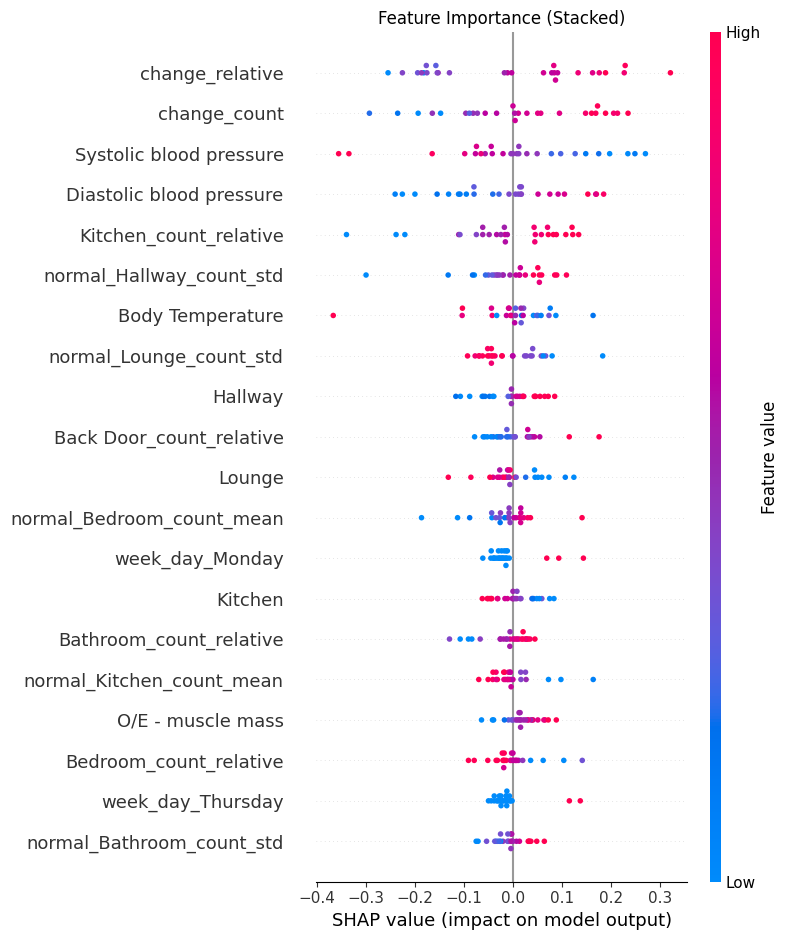

    feature  importance  cumulative_importance
0        10    0.146386               0.089446
1         9    0.118889               0.162091
2        46    0.112184               0.230639
3        47    0.095870               0.289218
4        22    0.088008               0.342993
5        44    0.056963               0.377799
6        45    0.053289               0.410361
7        43    0.051653               0.441922
8        20    0.042521               0.467903
9        25    0.040334               0.492549
10       19    0.038808               0.516261
11       32    0.035877               0.538183
12        1    0.034769               0.559428
13       14    0.032879               0.579518
14       26    0.032474               0.599360
15       30    0.031432               0.618566
16       50    0.031086               0.637561
17       24    0.030504               0.656200
18        4    0.029118               0.673992
19       42    0.026547               0.690213
20       40  

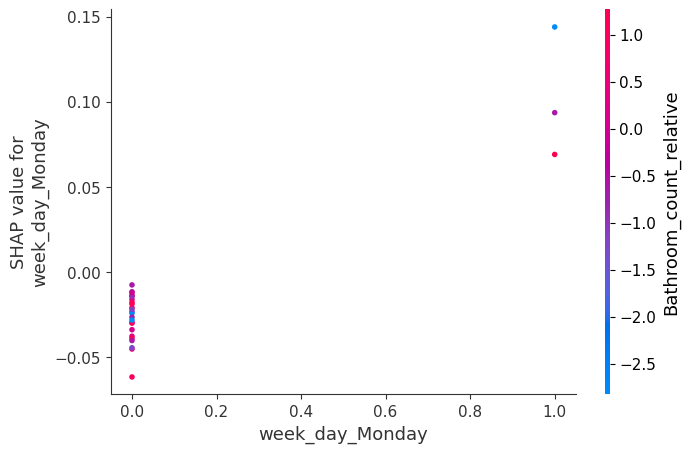

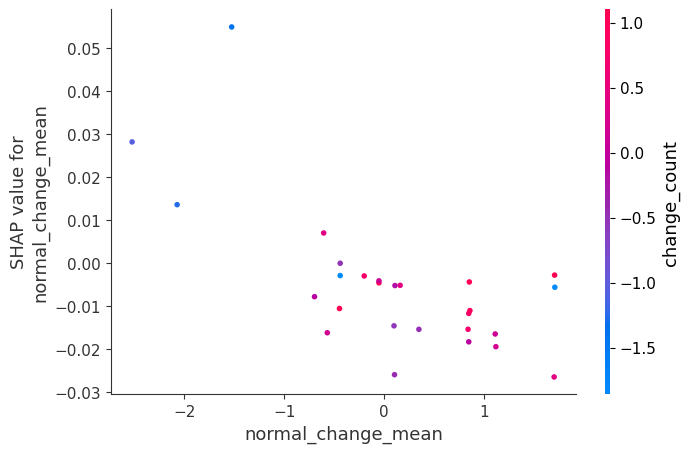

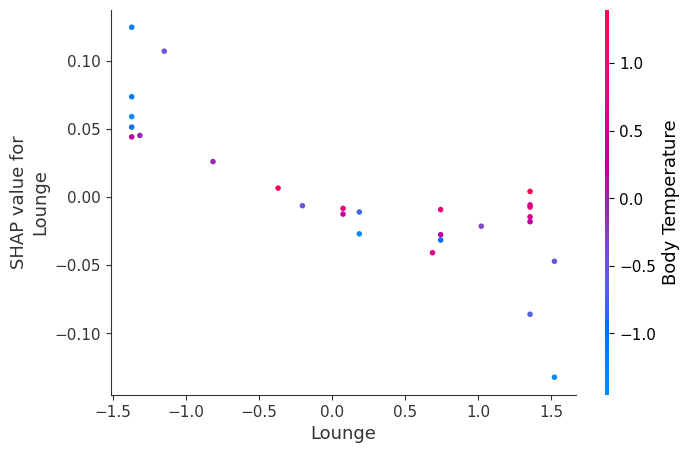

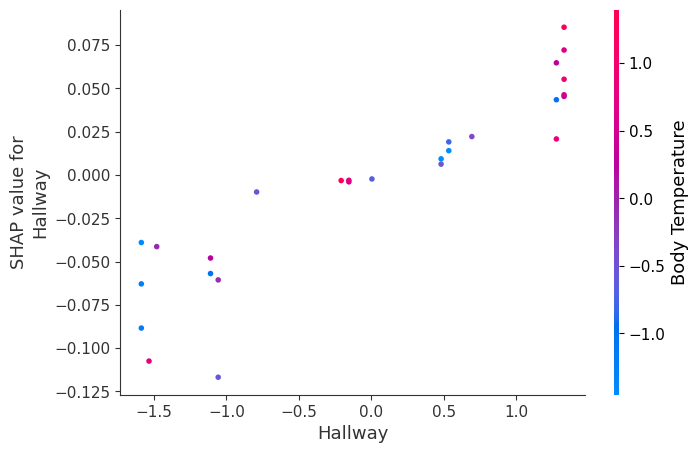

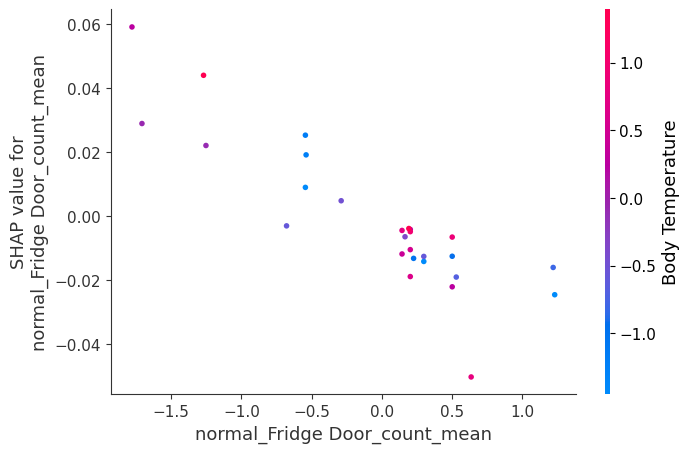

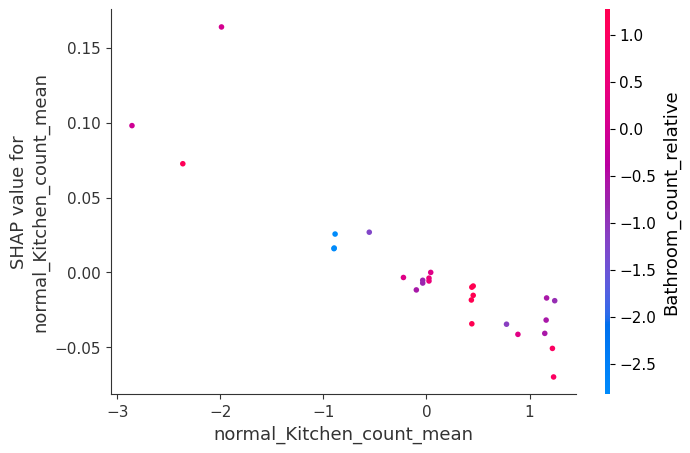

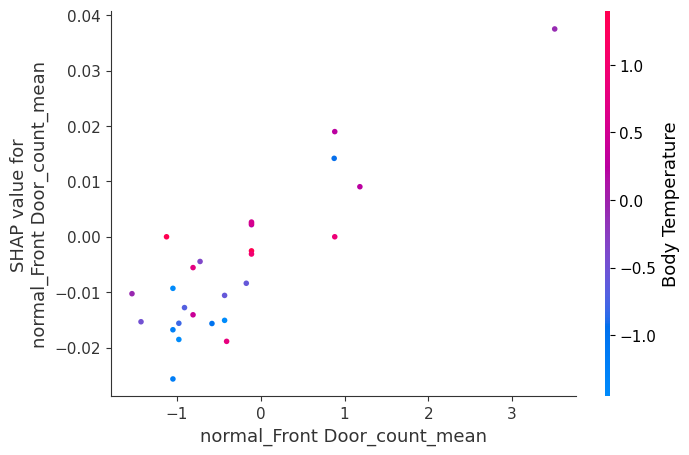

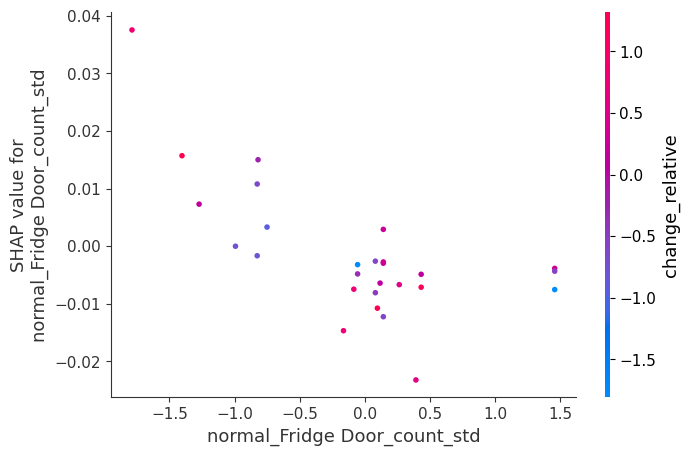

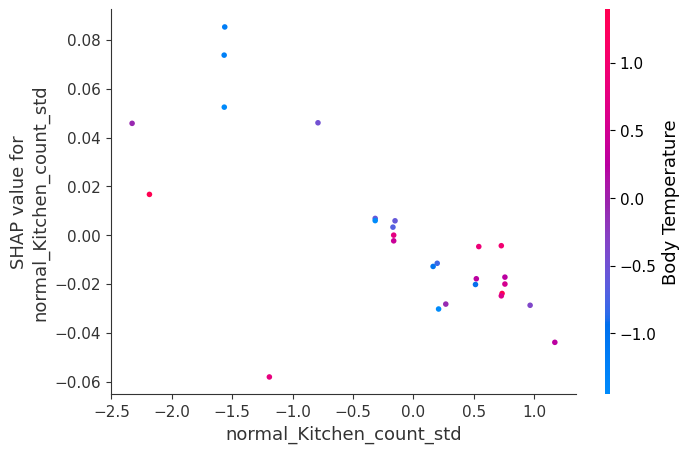

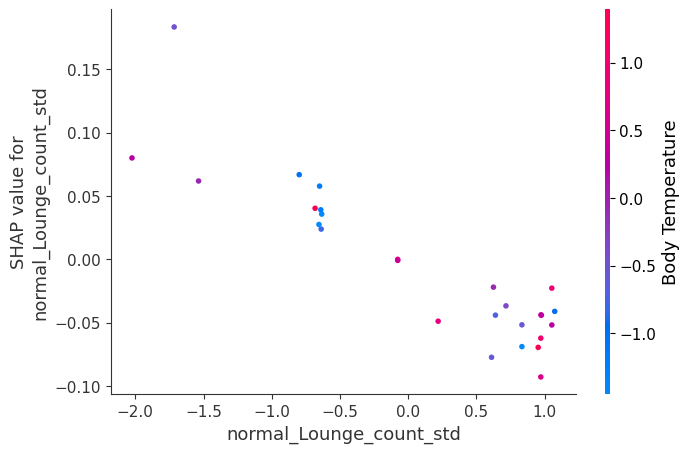

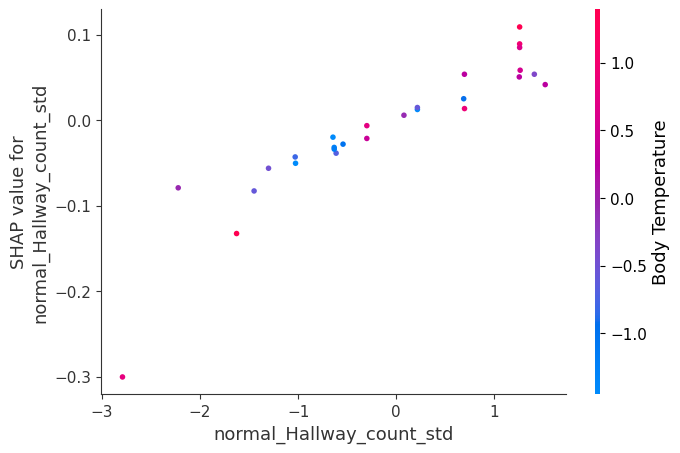

In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import shap

# Generate synthetic dataset
np.random.seed(42)

# Define and train the MLP model
model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate PR AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall_curve, precision_curve)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"PR AUC: {pr_auc:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Compute SHAP values
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

# Create a single figure for visualizing feature importance
plt.figure(figsize=(10, 6))

# Plot summary of feature importance
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title('Feature Importance (Stacked)')

plt.tight_layout()
plt.show()

# Calculate cumulative importance of features
shap_values_mean = np.mean(np.abs(shap_values), axis=0)  # mean absolute SHAP values
feature_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': shap_values_mean})
feature_importance = feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()

# Display feature importance and cumulative importance
print(feature_importance)

# Identify negative impact features
negative_impact_features = [i for i in range(X_train.shape[1]) if (shap_values[:, i] < 0).mean() > 0.5]
print("\nFeatures with negative impact:", negative_impact_features)

# Check correlation with target
correlation = pd.DataFrame(X_train).corrwith(pd.Series(y_train))
harmful_features = [feature for feature in negative_impact_features if correlation[feature] < 0]
print("\nHarmful features:", harmful_features)

# Create dependence plots for harmful features
for feature in harmful_features:
    shap.dependence_plot(feature, shap_values, X_test)


Accuracy: 0.59
F1 Score: 0.56
Precision: 0.58
Sensitivity (Recall): 0.54
Specificity: 0.64
PR AUC: 0.67
ROC AUC: 0.59

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62        14
           1       0.58      0.54      0.56        13

    accuracy                           0.59        27
   macro avg       0.59      0.59      0.59        27
weighted avg       0.59      0.59      0.59        27



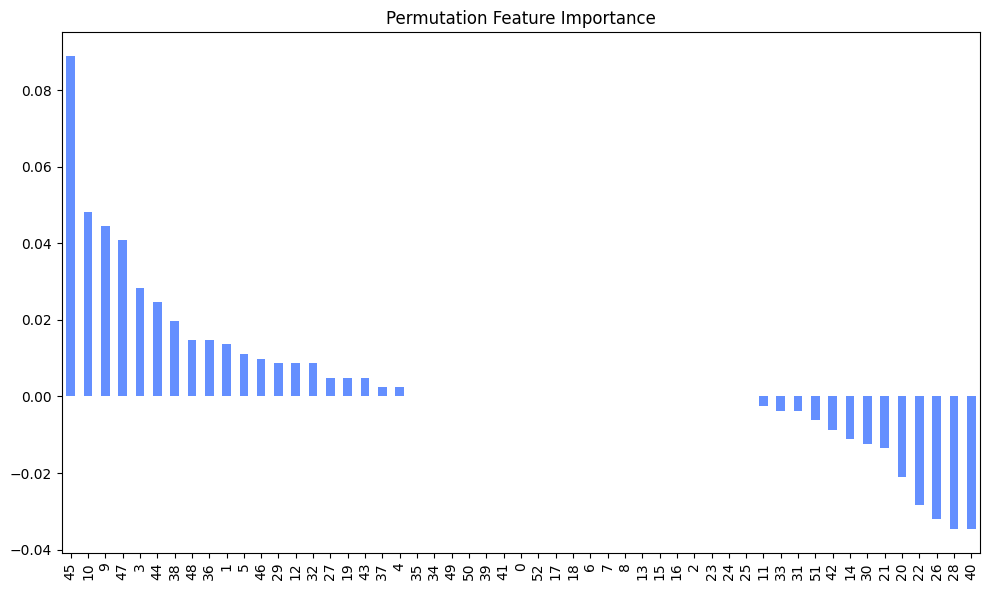

    feature    importance  cumulative_importance
0        45  8.888889e-02               0.461538
1        10  4.814815e-02               0.711538
2         9  4.444444e-02               0.942308
3        47  4.074074e-02               1.153846
4         3  2.839506e-02               1.301282
5        44  2.469136e-02               1.429487
6        38  1.975309e-02               1.532051
7        48  1.481481e-02               1.608974
8        36  1.481481e-02               1.685897
9         1  1.358025e-02               1.756410
10        5  1.111111e-02               1.814103
11       46  9.876543e-03               1.865385
12       29  8.641975e-03               1.910256
13       12  8.641975e-03               1.955128
14       32  8.641975e-03               2.000000
15       27  4.938272e-03               2.025641
16       19  4.938272e-03               2.051282
17       43  4.938272e-03               2.076923
18       37  2.469136e-03               2.089744
19        4  2.46913

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.inspection import permutation_importance

# Generate synthetic dataset
np.random.seed(42)

# Define and train the MLP model
model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate PR AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall_curve, precision_curve)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"PR AUC: {pr_auc:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Compute Permutation Feature Importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Create a single figure for visualizing feature importance
plt.figure(figsize=(10, 6))

# Plot summary of feature importance
feature_importance = pd.Series(perm_importance.importances_mean, index=range(X_train.shape[1]))
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Permutation Feature Importance')

plt.tight_layout()
plt.show()

# Calculate cumulative importance of features
feature_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': perm_importance.importances_mean})
feature_importance = feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()

# Display feature importance and cumulative importance
print(feature_importance)


In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import lime
import lime.lime_tabular

seed = 42
np.random.seed(seed)


X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_val, y_val = X_val.to_numpy(), y_val.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

# Define and train the MLP model
model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=seed)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate PR AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall_curve, precision_curve)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"PR AUC: {pr_auc:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, mode='classification', feature_names=[f'Feature {i}' for i in range(X_train.shape[1])], class_names=['Class 0', 'Class 1'], discretize_continuous=True)

# Explain a single instance
i = 0  # Index of the instance you want to explain
exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=n_features)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)


Accuracy: 0.59
F1 Score: 0.56
Precision: 0.58
Sensitivity (Recall): 0.54
Specificity: 0.64
PR AUC: 0.67
ROC AUC: 0.59

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62        14
           1       0.58      0.54      0.56        13

    accuracy                           0.59        27
   macro avg       0.59      0.59      0.59        27
weighted avg       0.59      0.59      0.59        27



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

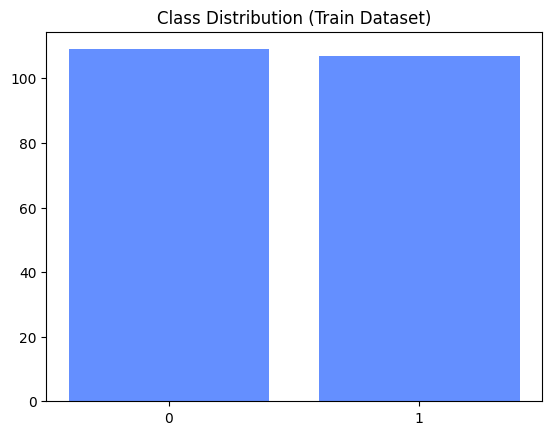

In [281]:
count_one = np.sum(y_train)
count_zero = len(y_train) - count_one
plt.bar(['0', '1'], [count_zero, count_one])
plt.title('Class Distribution (Train Dataset)')
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

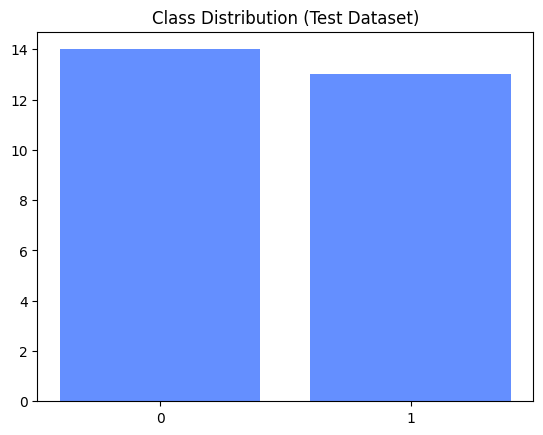

In [282]:
count_one = np.sum(y_test)
count_zero = len(y_test) - count_one
plt.bar(['0', '1'], [count_zero, count_one])
plt.title('Class Distribution (Test Dataset)')
plt